In [ ]:
# !pip install numpy scikit-learn Pillow pathlib

In [1]:
from utils.simplecnn import SimpleCNN
from utils.fgsm import generate_image_adversary
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from utils.cifar_10 import load_data
import numpy as np
from PIL import Image, ImageOps, ImageDraw, ImageFont
from copy import deepcopy

In [ ]:
# ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
# !tar -zxvf cifar-10-python.tar.gz

In [2]:
# Specify font to draw text on image
font = ImageFont.truetype("arial.ttf", 9)

In [ ]:
# Load the CIFAR-10 dataset. If server is down (error 503), follow the big comment below.
# If facing certificate error, follow this: https://stackoverflow.com/questions/69687794/unable-to-manually-load-cifar10-dataset

# Download/Get the Python3-compatible CIFAR-10 dataset from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz or anywhere else.
# Make sure tar.gz file is fully unzipped and in the same location as this .py file.
# Use "tar -zxvf cifar-10-python.tar.gz" command to completely unzip the CIFAR-10 dataset to get a directory
# named "cifar-10-batches-py" in the same location as this current .py file.

# print("[INFO] Loading CIFAR-10 dataset...")
# (trainX, trainY), (testX, testY) = cifar10.load_data()

In [3]:
# Load the CIFAR-10 dataset
print("[INFO] Loading CIFAR-10 dataset...")
(trainX, trainY), (testX, testY) = load_data()

[INFO] Loading CIFAR-10 dataset...


In [4]:
# Scale the pixel values to the range [0, 1]
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

In [5]:
# Add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

In [6]:
# One-hot encode the labels
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

In [7]:
# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [8]:
# Initialize the optimizer and the model
print("[INFO] Compiling the model...")
opt = Adam(lr=1e-3)
model = SimpleCNN.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] Compiling the model...


/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-05-08 12:57:17.073424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 12:57:17.161677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 12:57:17.162610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 12:57:17.168279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (

In [9]:
# Train the simple CNN on the CIFAR-10 dataset
print("[INFO] Training the network...")
model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=64, epochs=10, verbose=1)

[INFO] Training the network...
Epoch 1/10


2022-05-08 12:57:27.598834: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


782/782 [==============================] - 14s 13ms/step - loss: 1.6535 - accuracy: 0.4362 - val_loss: 1.3164 - val_accuracy: 0.5397
Epoch 2/10
782/782 [==============================] - 9s 11ms/step - loss: 1.1948 - accuracy: 0.5773 - val_loss: 1.0633 - val_accuracy: 0.6188
Epoch 3/10
782/782 [==============================] - 9s 11ms/step - loss: 1.0327 - accuracy: 0.6354 - val_loss: 0.9893 - val_accuracy: 0.6489
Epoch 4/10
782/782 [==============================] - 9s 12ms/step - loss: 0.9345 - accuracy: 0.6732 - val_loss: 0.9692 - val_accuracy: 0.6561
Epoch 5/10
782/782 [==============================] - 8s 11ms/step - loss: 0.8564 - accuracy: 0.6984 - val_loss: 1.0421 - val_accuracy: 0.6430
Epoch 6/10
782/782 [==============================] - 9s 11ms/step - loss: 0.7916 - accuracy: 0.7212 - val_loss: 0.9307 - val_accuracy: 0.6766
Epoch 7/10
782/782 [==============================] - 9s 11ms/step - loss: 0.7289 - accuracy: 0.7444 - val_loss: 0.9186 - val_accuracy: 0.6851
Epoch 8/1

In [23]:
model.save('naive_model')

INFO:tensorflow:Assets written to: naive_model/assets


In [11]:
# Make predictions on the testing set for the model trained on non-adversarial images
(loss, acc) = model.evaluate(x=testX, y=testY, verbose=0)
print("[INFO] Loss: {:.4f}, Accuracy: {:.4f}".format(loss, acc))

[INFO] Loss: 0.9951, Accuracy: 0.6815


In [24]:
# Loop over a sample of the testing images
for i in np.random.choice(np.arange(0, len(testX)), size=(10,)):
    # Grab the current image and label
    image = testX[i]
    label = testY[i]
    # Generate an image adversary for the current image and make a prediction on the adversary image
    adversary = generate_image_adversary(model, image.reshape(1, 32, 32, 3), label, eps=0.01)
    pred = model.predict(adversary)
    # Scale both the original image and the adversary image to the range [0, 255]
    # and convert them to unsigned 8-bit integers
    adversary = adversary.reshape((32, 32, 3)) * 255
    adversary = np.clip(adversary, 0, 255).astype("uint8")
    image = image.reshape((32, 32, 3)) * 255
    image = image.astype("uint8")
    # # Convert the image and adversarial image from grayscale to three channel (in order to draw on the image)
    # image = np.dstack([image] * 3)
    # adversary = np.dstack([adversary] * 3)
    # Resize the images in order to visualize them later
    image = Image.fromarray(image).resize((96, 96))
    adversary = Image.fromarray(adversary).resize((96, 96))
    # image = cv2.resize(image, (96, 96))
    # adversary = cv2.resize(adversary, (96, 96))
    # Determine the predicted label for both the original image and the adversarial image
    imagePred = label.argmax()
    adversaryPred = pred[0].argmax()
    color = (0, 255, 0)
    # If the image prediction does not match with the adversarial prediction then update the color
    if imagePred != adversaryPred:
        color = (255, 0, 0)
    # Draw the predictions on the respective output images
    # cv2.putText(image, str(imagePred), (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.95, (0, 255, 0), 2)
    # cv2.putText(adversary, str(adversaryPred), (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)
    image_copy = deepcopy(image)
    adversary_copy = deepcopy(adversary)
    draw_image = ImageDraw.Draw(image_copy)
    draw_image.text((10, 10), "{}".format(labelNames[imagePred]), (0,255,0), font=font)
    draw_adversary = ImageDraw.Draw(adversary_copy)
    draw_adversary.text((10, 10), "{}".format(labelNames[adversaryPred]), color, font=font)
    # Stack the two images horizontally and then show the original image and its adversary
    output = np.hstack([image_copy, adversary_copy])
    # cv2.imshow("FGSM Adversarial Images", output)
    # cv2.waitKey(0)
    Image.fromarray(output)

In [12]:
# # Grab the current image and label
# image = testX[7]
# label = testY[7]

In [ ]:
# label

In [13]:
# # Generate an image adversary for the current image and make a prediction on the adversary image
# adversary = generate_image_adversary(model, image.reshape(1, 32, 32, 3), label, eps=0.01)
# pred = model.predict(adversary)

In [ ]:
# pred

In [14]:
# # Scale both the original image and the adversary image to the range [0, 255]
# # and convert them to unsigned 8-bit integers
# adversary = adversary.reshape((32, 32, 3)) * 255
# adversary = np.clip(adversary, 0, 255).astype("uint8")
# image = image.reshape((32, 32, 3)) * 255
# image = image.astype("uint8")

In [15]:
# # Resize the images in order to visualize them later
# image = Image.fromarray(image).resize((96, 96))
# adversary = Image.fromarray(adversary).resize((96, 96))

In [16]:
# # Determine the predicted label for both the original image and the adversarial image
# imagePred = label.argmax()
# adversaryPred = pred[0].argmax()

In [17]:
# color = (0, 255, 0)
# # If the image prediction does not match with the adversarial prediction then update the color
# if imagePred != adversaryPred:
#     color = (255, 0, 0)

In [18]:
# font = ImageFont.truetype("arial.ttf", 9)

In [19]:
# image_copy = deepcopy(image)
# adversary_copy = deepcopy(adversary)

In [20]:
# draw_image = ImageDraw.Draw(image_copy)
# draw_image.text((10, 10), "{}".format(labelNames[imagePred]), (0,255,0), font=font)

# draw_adversary = ImageDraw.Draw(adversary_copy)
# draw_adversary.text((10, 10), "{}".format(labelNames[adversaryPred]), color, font=font)

In [21]:
# output = np.hstack([image_copy, adversary_copy])

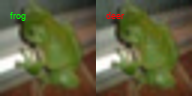

In [22]:
# Image.fromarray(output)